In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import PIL
import cv2
import requests
from io import BytesIO
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.backend import clear_session

from tensorflow.keras.applications import InceptionResNetV2,InceptionV3
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.xception import Xception

In [ ]:
#INPUT_DIR = '/kaggle/input/70-dog-breedsimage-data-set'
#OUTPUT_DIR = '/kaggle/working/'

TRAIN_DIR = '/content/drive/MyDrive/DLMINI/train'
VAL_DIR = '/content/drive/MyDrive/DLMINI/valid'
TEST_DIR = '/content/drive/MyDrive/DLMINI/test'

DIMS = (224,224)
IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 42

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
data_gen = ImageDataGenerator(rescale=1/255)

In [ ]:
train_data = data_gen.flow_from_directory(batch_size=BATCH_SIZE, directory=TRAIN_DIR, shuffle=True,
                                            target_size=DIMS, class_mode='categorical')

val_data = data_gen.flow_from_directory(batch_size=BATCH_SIZE, directory=VAL_DIR, shuffle=True,
                                            target_size=DIMS, class_mode='categorical')

test_data = data_gen.flow_from_directory(batch_size=BATCH_SIZE, directory=TEST_DIR, shuffle=True,
                                            target_size=DIMS, class_mode='categorical')

Found 7946 images belonging to 70 classes.
Found 700 images belonging to 70 classes.
Found 700 images belonging to 70 classes.


In [ ]:
label_mapper = np.asarray(list(train_data.class_indices.keys()))
label_mapper

array(['Afghan', 'African Wild Dog', 'Airedale', 'American Hairless',
       'American Spaniel', 'Basenji', 'Basset', 'Beagle',
       'Bearded Collie', 'Bermaise', 'Bichon Frise', 'Blenheim',
       'Bloodhound', 'Bluetick', 'Border Collie', 'Borzoi',
       'Boston Terrier', 'Boxer', 'Bull Mastiff', 'Bull Terrier',
       'Bulldog', 'Cairn', 'Chihuahua', 'Chinese Crested', 'Chow',
       'Clumber', 'Cockapoo', 'Cocker', 'Collie', 'Corgi', 'Coyote',
       'Dalmation', 'Dhole', 'Dingo', 'Doberman', 'Elk Hound',
       'French Bulldog', 'German Sheperd', 'Golden Retriever',
       'Great Dane', 'Great Perenees', 'Greyhound', 'Groenendael',
       'Irish Spaniel', 'Irish Wolfhound', 'Japanese Spaniel', 'Komondor',
       'Labradoodle', 'Labrador', 'Lhasa', 'Malinois', 'Maltese',
       'Mex Hairless', 'Newfoundland', 'Pekinese', 'Pit Bull',
       'Pomeranian', 'Poodle', 'Pug', 'Rhodesian', 'Rottweiler',
       'Saint Bernard', 'Schnauzer', 'Scotch Terrier', 'Shar_Pei',
       'Shiba In

In [ ]:
IMG_SHAPE = (224,224,3)
base_model = InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet', classes=70)

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(100,activation='relu'))
model.add(Dense(70,activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 100)               204900    
                                                                 
 dense_1 (Dense)             (None, 70)                7070      
                                                                 
Total params: 22014754 (83.98 MB)
Trainable params: 211970 (828.01 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='loss', patience=5, verbose=2, factor=0.001)
es = EarlyStopping(monitor='loss', verbose=2, patience=10, min_delta=0.001)

In [ ]:
logs = model.fit(train_data, validation_data=val_data,
                steps_per_epoch = train_data.samples//BATCH_SIZE,
                validation_steps = val_data.samples//BATCH_SIZE,
                epochs=10, verbose=1, callbacks=[reduce_lr,es])

Epoch 1/10
248/248 [==============================] - 2257s 9s/step - loss: 1.0373 - accuracy: 0.7516 - val_loss: 0.6636 - val_accuracy: 0.8542 - lr: 0.0100
Epoch 2/10
248/248 [==============================] - 44s 176ms/step - loss: 0.5921 - accuracy: 0.8389 - val_loss: 0.8429 - val_accuracy: 0.8438 - lr: 0.0100
Epoch 3/10
248/248 [==============================] - 44s 176ms/step - loss: 0.5496 - accuracy: 0.8554 - val_loss: 0.8807 - val_accuracy: 0.8631 - lr: 0.0100
Epoch 4/10
248/248 [==============================] - 44s 177ms/step - loss: 0.5746 - accuracy: 0.8496 - val_loss: 1.0950 - val_accuracy: 0.8348 - lr: 0.0100
Epoch 5/10
248/248 [==============================] - 43s 172ms/step - loss: 0.5115 - accuracy: 0.8664 - val_loss: 0.7701 - val_accuracy: 0.8958 - lr: 0.0100
Epoch 6/10
248/248 [==============================] - 42s 171ms/step - loss: 0.5256 - accuracy: 0.8729 - val_loss: 0.8299 - val_accuracy: 0.9092 - lr: 0.0100
Epoch 7/10
248/248 [==============================] -

In [ ]:
clear_session()

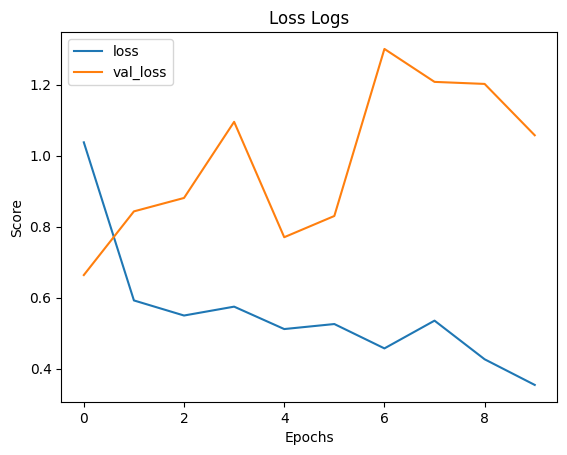

In [ ]:
plt.plot(logs.history['loss'], label='loss')
plt.plot(logs.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Loss Logs')
plt.show()

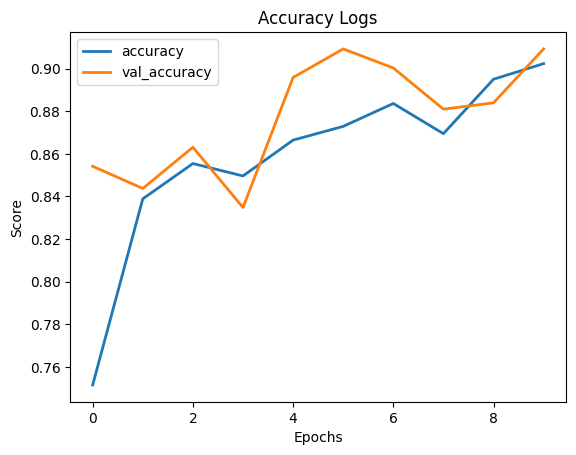

In [ ]:
plt.plot(logs.history['accuracy'], label='accuracy', linewidth=2)
plt.plot(logs.history['val_accuracy'], label='val_accuracy', linewidth=2)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Accuracy Logs')
plt.show()

In [ ]:
model.evaluate(val_data)

22/22 [==============================] - 7s 298ms/step - loss: 1.0203 - accuracy: 0.9114


[1.0202971696853638, 0.9114285707473755]

In [ ]:
model.evaluate(test_data)

22/22 [==============================] - 180s 9s/step - loss: 0.3747 - accuracy: 0.9186


[0.3746749460697174, 0.918571412563324]

In [ ]:
def predictor(img):
    display(img)
    arr = img_to_array(img)
    arr = arr/255.0
    arr = np.expand_dims(arr,0)
    res = model.predict(arr)
    print(res.shape)
    idx = res.argmax()
    return label_mapper[idx], res[0][idx]

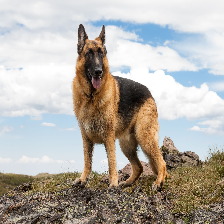

1/1 [==============================] - 3s 3s/step
(1, 70)


('German Sheperd', 0.8694241)

In [ ]:
url = 'https://www.google.com/url?sa=i&url=https%3A%2F%2Fencrypted-tbn3.gstatic.com%2Flicensed-image%3Fq%3Dtbn%3AANd9GcRv7Ev1T8O6as52YDwz3YDa9ya3-xv5SpMw3Lk_mZHqxwWvGDCw47ZaixFiTefWHF_dHHqDFFSYk2ZRKfU&psig=AOvVaw2brgj8mLWs5S3os1vdjdgh&ust=1690324655029000&source=images&cd=vfe&opi=89978449&ved=0CBEQjRxqFwoTCMDy4pa0qIADFQAAAAAdAAAAABAE'
response = requests.get(url)
img = load_img(BytesIO(response.content), target_size=DIMS)

val,prob = predictor(img)
val,prob

InceptionResNetV2

In [ ]:
base_model = InceptionResNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet', classes=70)
base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(100,activation='relu'))
model.add(Dense(70,activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
reduce_lr = ReduceLROnPlateau(monitor='loss', patience=5, verbose=2, factor=0.001)
es = EarlyStopping(monitor='loss', verbose=2, patience=10, min_delta=0.001)
logs = model.fit(train_data, validation_data=val_data,
                steps_per_epoch = train_data.samples//BATCH_SIZE,
                validation_steps = val_data.samples//BATCH_SIZE,
                epochs=10, verbose=1, callbacks=[reduce_lr,es])


219055592/219055592 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 5, 5, 1536)        54336736  
 ional)                                                          
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 100)               153700    
                                                                 
 dense_1 (Dense)             (None, 70)                7070      
                                                                 
Total params: 54497506 (207.89 MB)
Trainable params: 160770 (628.01 KB)
Non-trainable params: 54336736 (207.28 MB)
______

VGG19

In [ ]:
from tensorflow.keras.applications import VGG19

base_model = VGG19(input_shape=IMG_SHAPE, include_top=False, weights='imagenet', classes=70)
base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(100, activation='relu'))
model.add(Dense(70, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

reduce_lr = ReduceLROnPlateau(monitor='loss', patience=5, verbose=2, factor=0.001)
es = EarlyStopping(monitor='loss', verbose=2, patience=10, min_delta=0.001)

logs = model.fit(train_data, validation_data=val_data,
                steps_per_epoch=train_data.samples//BATCH_SIZE,
                validation_steps=val_data.samples//BATCH_SIZE,
                epochs=10, verbose=1, callbacks=[reduce_lr, es])


80134624/80134624 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 100)               51300     
                                                                 
 dense_3 (Dense)             (None, 70)                7070      
                                                                 
Total params: 20082754 (76.61 MB)
Trainable params: 58370 (228.01 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________
Epoch 1/1

MobileNetV2

In [ ]:
base_model = MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet', classes=70)
base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(100,activation='relu'))
model.add(Dense(70,activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
reduce_lr = ReduceLROnPlateau(monitor='loss', patience=5, verbose=2, factor=0.001)
es = EarlyStopping(monitor='loss', verbose=2, patience=10, min_delta=0.001)
logs = model.fit(train_data, validation_data=val_data,
                steps_per_epoch = train_data.samples//BATCH_SIZE,
                validation_steps = val_data.samples//BATCH_SIZE,
                epochs=10, verbose=1, callbacks=[reduce_lr,es])


9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 100)               128100    
                                                                 
 dense_5 (Dense)             (None, 70)                7070      
                                                                 
Total params: 2393154 (9.13 MB)
Trainable params: 135170 (528.01 KB)
Non-trainable params: 2257984 (8.61 MB)
______________

Xception

In [ ]:
from tensorflow.keras.applications.xception import Xception
base_model = Xception(input_shape=IMG_SHAPE, include_top=False, weights='imagenet', classes=70)
base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(100,activation='relu'))
model.add(Dense(70,activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
reduce_lr = ReduceLROnPlateau(monitor='loss', patience=5, verbose=2, factor=0.001)
es = EarlyStopping(monitor='loss', verbose=2, patience=10, min_delta=0.001)
logs = model.fit(train_data, validation_data=val_data,
                steps_per_epoch = train_data.samples//BATCH_SIZE,
                validation_steps = val_data.samples//BATCH_SIZE,
                epochs=10, verbose=1, callbacks=[reduce_lr,es])


83683744/83683744 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 100)               204900    
                                                                 
 dense_3 (Dense)             (None, 70)                7070      
                                                                 
Total params: 21073450 (80.39 MB)
Trainable params: 211970 (828.01 KB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________
Epoch 1/